# 👖 Variational Autoencoders - Fashion-MNIST

In [1]:
working_dir = "/home/mary/work/repos/generative_deep_Learning_2nd_edition_pytorch"
exp_dir = working_dir + "/notebooks/03_vae/02_vae_fashion/"

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the path to the notebooks folder
notebooks_path = os.path.abspath(working_dir)
if notebooks_path not in sys.path:
    sys.path.append(notebooks_path)

In [3]:
import torchvision
from torchvision import transforms
import torch
from notebooks.utils import display

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchinfo import summary

import torch.utils
import torch.utils.data
import math
import numpy as np
from scipy.stats import norm

## 0. Parameters <a name="parameters"></a>

In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 50
BETA = 500
CHANNELS = 1

## 1. Prepare the data <a name="prepare"></a>

In [5]:
data_dir = working_dir + "/data"

In [6]:
transform = transforms.Compose([
    transforms.Pad((2, 2, 2, 2)), # Padding (left, top, right, bottom)
    transforms.ToTensor()
    
])

train_data = torchvision.datasets.FashionMNIST(data_dir, train=True, transform=transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data = torchvision.datasets.FashionMNIST(data_dir, train=False, transform=transform, download=True)

test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [7]:
print(f"training data size= {len(train_data)}")
print(f"test data size= {len(test_data)}")

training data size= 60000
test data size= 10000


In [8]:
dataiter = iter(train_data_loader)
images, lables = next(dataiter)

print(type(images))
print(images.shape)

<class 'torch.Tensor'>
torch.Size([100, 1, 32, 32])


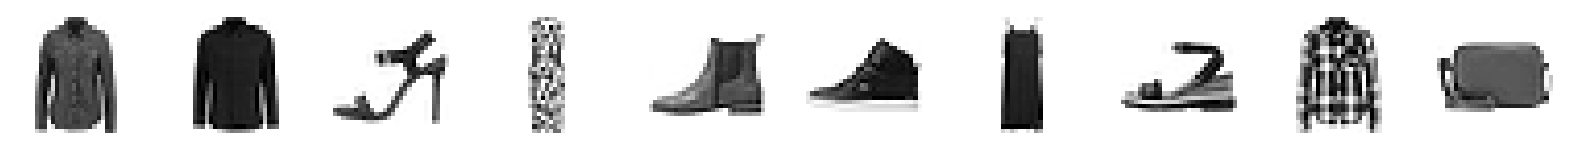

tensor([6, 6, 5, 3, 9, 7, 3, 5, 6, 8])


In [9]:
display(images[:10])
print(lables[:10])

## 2. Build the variational autoencoder <a name="build"></a>

In [10]:
class Sampling(nn.Module):
    def forward(self, inputs):
        z_mean, z_log_var = inputs
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        device = z_mean.device
        epsilon = torch.randn(size=(batch, dim)).to(device)
        sample = z_mean + torch.exp(0.5* z_log_var) * epsilon
        return sample

In [11]:
class Encoder(nn.Module):

    def __init__(self, image_size, channels):
        super().__init__()

        p = self._get_padding_size(image_size, 2, 3)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=2, padding=p)
        
        p = self._get_padding_size(image_size/2, 2, 3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=p)

        p = self._get_padding_size(image_size/4, 2, 3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=p)

        self.shape_before_flattening = (128, image_size/8, image_size/8)

        self.fc_mean = nn.Linear(in_features=int(math.prod(self.shape_before_flattening)), out_features=EMBEDDING_DIM)
        self.fc_log_var = nn.Linear(in_features=int(math.prod(self.shape_before_flattening)), out_features=EMBEDDING_DIM)

        self.sampling_layer = Sampling()

    def get_shape_before_flattening(self):
        return tuple(map(int, self.shape_before_flattening))
    
    @staticmethod
    def _get_padding_size(input_w, stride, kernal_size):
        p = ((input_w /2) - 1) * stride
        p = (p - input_w) + kernal_size
        p = math.ceil(p/2)

        return p
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        # # flatten
        x = x.view(x.shape[0], -1)
        
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_mean(x)

        z = self.sampling_layer((z_mean, z_log_var))
        
        return z_mean, z_log_var, z

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
endocde = Encoder(IMAGE_SIZE, CHANNELS).to(device)

print(endocde)


Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_mean): Linear(in_features=2048, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=2048, out_features=2, bias=True)
  (sampling_layer): Sampling()
)


In [13]:
summary(endocde, (1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

/home/mary/miniconda3/envs/nerfstudio_1.1/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 2]                    4,098
├─Conv2d: 1-1                            [1, 32, 16, 16]           320
├─Conv2d: 1-2                            [1, 64, 8, 8]             18,496
├─Conv2d: 1-3                            [1, 128, 4, 4]            73,856
├─Linear: 1-4                            [1, 2]                    4,098
├─Linear: 1-5                            [1, 2]                    (recursive)
├─Sampling: 1-6                          [1, 2]                    --
Total params: 100,868
Trainable params: 100,868
Non-trainable params: 0
Total mult-adds (M): 2.46
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.39
Estimated Total Size (MB): 0.51

In [14]:
class Decoder(nn.Module):
    def __init__(self, shape_before_flatten, channels):
        super().__init__()

        self.shape_before_flatten = shape_before_flatten

        self.fc1 = nn.Linear(in_features=EMBEDDING_DIM, out_features=int(math.prod(self.shape_before_flatten)))

        p = self._get_padding_size(self.shape_before_flatten[1], stride=2, kernaal_size=3)
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=self.shape_before_flatten[0], out_channels=128, 
                                              kernel_size=3, stride=2, padding=1, output_padding=1)
        
        p = self._get_padding_size(self.shape_before_flatten[1]*2, stride=2, kernaal_size=3)
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, 
                                              stride=2, padding=p, output_padding=1)
        
        p = self._get_padding_size(self.shape_before_flatten[1]*4, stride=2, kernaal_size=3)
        self.conv_trans3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,
                                              stride=2, padding=p, output_padding=1)
        
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=channels, kernel_size=3,
                               stride=1, padding='same')
        
    @staticmethod
    def _get_padding_size(input_w, stride, kernaal_size):
        p = ((input_w - 1) * stride) / 2
        p = p - input_w
        p = p + (kernaal_size / 2)
        p = p + 1/2
        return math.ceil(p)
    
    def forward(self, x):
        x = self.fc1(x)
        c, w, h = self.shape_before_flatten
        x = x.view(-1, c, w, h)
        x = self.conv_trans1(x)
        x = F.relu(x)
        x = self.conv_trans2(x)
        x = F.relu(x)
        x = self.conv_trans3(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.sigmoid(x)
        # Should we add sigmoid?

        return x

In [15]:
shape_before_faltten = endocde.get_shape_before_flattening()
decoder = Decoder(shape_before_faltten, CHANNELS).to(device)
print(decoder)

Decoder(
  (fc1): Linear(in_features=2, out_features=2048, bias=True)
  (conv_trans1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv_trans2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv_trans3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv1): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
)


In [16]:
summary(decoder, (1, EMBEDDING_DIM,))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 1, 32, 32]            --
├─Linear: 1-1                            [1, 2048]                 6,144
├─ConvTranspose2d: 1-2                   [1, 128, 8, 8]            147,584
├─ConvTranspose2d: 1-3                   [1, 64, 16, 16]           73,792
├─ConvTranspose2d: 1-4                   [1, 32, 32, 32]           18,464
├─Conv2d: 1-5                            [1, 1, 32, 32]            289
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (M): 47.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.99
Estimated Total Size (MB): 1.47

In [17]:
class var_autoencoder(nn.Module):
    def __init__(self, image_size, channels, log_dir="./log"):
        super().__init__()
        self.encoder = Encoder(image_size, channels)
        shape_before_flatten = self.encoder.get_shape_before_flattening()
        self.decoder = Decoder(shape_before_flatten, channels)

        # tensorboard writer
        self.writer_train = SummaryWriter(log_dir + "/train")
        self.writer_val = SummaryWriter(log_dir + "/val")
    
    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        images = self.decoder(z)

        return z_mean, z_log_var, images
    
    def train_step(self, train_data_loader, optimizer):
        # training
        self.train()
        acc_loss, acc_rec_loss, acc_var_loss = 0, 0, 0


        for x_train, _ in train_data_loader:
            x_train = x_train.to(self.device)

            optimizer.zero_grad()

            z_mean, z_log_var, rec_images = self.forward(x_train)

            rec_loss = self.rec_loss_fn(rec_images, x_train)
            var_loss = self.var_loss_fn(z_mean, z_log_var)
            total_loss = (rec_loss * self.beta) + var_loss

            total_loss.backward()
            optimizer.step()

            acc_loss += total_loss.item()
            acc_rec_loss += rec_loss.item()
            acc_var_loss += var_loss.item()
        
        return({"rec_loss": acc_rec_loss/len(train_data_loader), 
                "var_loss": acc_var_loss/len(train_data_loader), 
                "total_loss": acc_loss/len(train_data_loader)})
            
    def eval_step(self, test_data_loader):
        # evaluation
        self.eval()

        eval_acc_loss, eval_acc_rec_loss, eval_acc_var_loss = 0, 0, 0
        with torch.no_grad():
            for x_test, _ in test_data_loader:
                x_test = x_test.to(self.device)

                z_mean, z_log_var, rec_images = self.forward(x_test)

                
                eval_rec_loss = self.rec_loss_fn(rec_images, x_test)
                eval_var_loss = self.var_loss_fn(z_mean, z_log_var)
                eval_total_loss = (eval_rec_loss * self.beta) + eval_var_loss
                
                eval_acc_rec_loss += eval_rec_loss.item()
                eval_acc_var_loss += eval_var_loss.item()
                eval_acc_loss += eval_total_loss.item()

        return({"rec_loss": eval_acc_rec_loss/len(test_data_loader), 
                "var_loss": eval_acc_var_loss/len(test_data_loader), 
                "total_loss": eval_acc_loss/len(test_data_loader)})

    def save_checkpoint(self, optimizer, epoch, loss, checkpoint_dir):
        checkpoint = {
            "epoch":epoch,
            "model_state_dict":self.state_dict(),
            "optimizer_state_dict":optimizer.state_dict(),
            "loss":loss
        }
        checkpoint_file = checkpoint_dir + f"/checkpoint_epoch_{epoch}.pth"
        torch.save(checkpoint, checkpoint_file)

    def fit(self, train_data_loader, test_data_loader, optimizer,
            rec_loss_fn, var_loss_fn, device, epochs=10, beta=500, checkpoint_dir="./checkpoint"):
        
        self.rec_loss_fn = rec_loss_fn
        self.var_loss_fn = var_loss_fn
        self.device = device
        self.beta = beta
        
        for i in range(epochs):

            train_losses = self.train_step(train_data_loader, optimizer)

            eval_losses = self.eval_step(test_data_loader)

            
            # log to tensor board
            # self.writer.add_scalar('rec_loss', {'train': train_losses['rec_loss'],
            #                                     'val':eval_losses['rec_loss'] }, global_step=i)
            self.writer_train.add_scalar("rec_loss",train_losses['rec_loss'], global_step=i)
            self.writer_train.add_scalar("kl_loss",train_losses['var_loss'], global_step=i)
            self.writer_train.add_scalar("total_loss",train_losses['total_loss'], global_step=i)
            
            self.writer_val.add_scalar("rec_loss", eval_losses['rec_loss'], global_step=i)
            self.writer_val.add_scalar("kl_loss", eval_losses['var_loss'], global_step=i)
            self.writer_val.add_scalar("total_loss", eval_losses['total_loss'], global_step=i)


            # save checkpoint
            self.save_checkpoint(optimizer, i, train_losses, checkpoint_dir)

            print(
                f"Epoch {i}/{epochs}: Training: rec_loss: {train_losses['rec_loss'] :.4f} "
                f"var_loss: {train_losses['var_loss']:.4f} "
                f"total_loss: {train_losses['total_loss']:.4f}"
            )
            
            print(
                f"Epoch {i}/{epochs}: Evaluation: rec_loss: {eval_losses['rec_loss']:.4f} "
                f"var_loss: {eval_losses['var_loss']:.4f} "
                f"total_loss: {eval_losses['total_loss'] :.4f}"
            )
            
            print()

In [18]:
log_dir =  exp_dir + "/log"
os.makedirs(log_dir, exist_ok=True)

vae = var_autoencoder(IMAGE_SIZE, CHANNELS, log_dir=log_dir).to(device)
print(vae)

var_autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mean): Linear(in_features=2048, out_features=2, bias=True)
    (fc_log_var): Linear(in_features=2048, out_features=2, bias=True)
    (sampling_layer): Sampling()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=2048, bias=True)
    (conv_trans1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv_trans2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv_trans3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv1): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
)


In [ ]:
def kl_loss(z_mean, z_log_var):
    B = z_mean.shape[0]
    loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    # get the mean loss
    loss = loss / B
    return loss


## 3. Train the variational autoencoder <a name="train"></a>

In [20]:
learning_rate=0.0005

In [21]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [22]:
reconstruction_loss_fn =  nn.BCELoss()
var_loss_fn = kl_loss

In [23]:
checkpoint_dir =  exp_dir + "/checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

vae.fit(train_data_loader=train_data_loader, test_data_loader=test_data_loader,
        optimizer=optimizer, rec_loss_fn=reconstruction_loss_fn, var_loss_fn=var_loss_fn, 
        device=device, epochs=EPOCHS, beta=BETA, checkpoint_dir=checkpoint_dir)

KeyboardInterrupt: 

In [ ]:
# save the trained models
model_dir = exp_dir + "/models"
os.makedirs(model_dir, exist_ok=True)

torch.save(vae.encoder.state_dict(), model_dir + "/encoder")
torch.save(vae.decoder.state_dict(), model_dir+"/decoder")
torch.save(vae.state_dict(), model_dir+"/vae")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [ ]:
n_to_predict = 5000
print(len(test_data))
test_iter = iter(test_data_loader)
example_images, example_lables = [], []

while (len(example_images)*BATCH_SIZE) < n_to_predict:
    test_images_batch, test_lables_batch = next(test_iter)
    example_images.append(test_images_batch)
    example_lables.append(test_lables_batch)

example_images = torch.stack(example_images)
w, h, c = example_images.shape[2:]
example_images = example_images.view(-1, w, h, c)

example_lables = torch.stack(example_lables).view(-1)

print(example_images.shape)
print(example_lables.shape)

In [ ]:
z_mean, z_log_var, rec_images = vae.forward(example_images.to(device))

In [ ]:
print("Example of real cloths")
display(example_images)
print("Example reconstrcuted images")
display(rec_images)

In [ ]:
train_data_iter = iter(train_data_loader)
sample_train, _ = next(train_data_iter)

In [ ]:
_, _, rec_example = vae.forward(sample_train.to(device))

In [ ]:
display(sample_train)
display(rec_example)

## 4. Embed using the encoder <a name="encode"></a>

In [ ]:
with torch.no_grad():
    z_mean, z_log_var, z = vae.encoder(example_images.to(device))

embeddings_np = z.to("cpu").detach().numpy()
print(embeddings_np[:10])

In [ ]:
if EMBEDDING_DIM == 2:
    figure_size = 8

    plt.figure(figsize=(figure_size, figure_size))
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1], c="black", s=3, alpha=0.5)
    plt.show()

## 6. Generate using the decoder <a name="decode"></a>

In [ ]:
mins, maxs = np.min(embeddings_np, axis=0), np.max(embeddings_np, axis=0)
print(mins)
print(maxs)
grid_width, grid_height = (6, 6)

samples = np.random.uniform(mins, maxs, (grid_width*grid_height, EMBEDDING_DIM))

print(samples[:3])

In [ ]:
type = z.dtype
with torch.no_grad():
    reconstructions = vae.decoder(torch.as_tensor(samples).to(type).to(device))

print(reconstructions.shape)
reconstructions_np = reconstructions.permute(0, 2, 3,1).to("cpu").detach().numpy()

In [ ]:
if EMBEDDING_DIM == 2:
    figure_size = 8

    plt.figure(figsize=(figure_size, figure_size))
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1], c="black", s=3, alpha=0.5)
    plt.scatter(samples[:, 0], samples[:, 1], c="blue", alpha=1, s=20)
    plt.show()

    # Add underneath a grid of the decoded images
    fig = plt.figure(figsize=(figure_size, grid_height * 2))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(grid_width * grid_height):
        ax = fig.add_subplot(grid_height, grid_width, i + 1)
        ax.axis("off")
        ax.text(
            0.5,
            -0.35,
            str(np.round(samples[i, :], 1)),
            fontsize=10,
            ha="center",
            transform=ax.transAxes,
        )
        ax.imshow(reconstructions_np[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(embeddings_np)
p_sample = norm.cdf(samples)

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    embeddings_np[:, 0], embeddings_np[:, 1], cmap="rainbow", c=example_lables, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_lables, alpha=0.8, s=3
)
plt.show()

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_lables, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = vae.decoder.forward(torch.as_tensor(grid).to(device).to(type))
reconstructions_np = reconstructions.permute(0, 2, 3,1).to("cpu").detach().numpy()
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions_np[i, :, :], cmap="Greys")